In [1]:
import numpy as np

## 1. Configuração do Spark

In [4]:
!pip install bitarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.3/340.3 kB 7.3 MB/s eta 0:00:00


In [5]:
import numpy as np
from pyspark.sql import SparkSession
from bitarray import bitarray

In [6]:
spark = (
    SparkSession.builder
    .appName("ButinaClustering80k")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.sql.execution.arrow.pyspark.enabled", "false")
    .getOrCreate()
)

sc = spark.sparkContext

## 2. Estabelecer indivíduos

In [7]:
qtd_individuos = 80000
qtd_caracteristicas = 166
np.random.seed(32)

In [8]:
## Criação de indivíduos. Serão criados X individuos, de acordo com o valor 'qtd_individuos' estabelecido; cada um com Y de características, de acordo com 'qtd_caracteristicas'.
# Foi estabelecida uma seed para garantir reprodutibilidade.
# Em "np.random.randint(0, 2, qtd_caracteristicas)", são gerados valores inteiros no intervalo de 0 (inclusivo) a 2 (exclusivo), resultando em vetores compostos apenas por 0 e 1, na quantidade estabelecida em 'qtd_caracteristicas'.

individuos = []

for i in range(qtd_individuos):
    bits = bitarray(np.random.randint(0, 2, qtd_caracteristicas).tolist())
    individuos.append((i, bits))

In [9]:
## Transformação em uma variável broadcast, em que dados grandes e imutáveis são compartilhados eficientemente como somente leitura,
# sendo enviados uma única vez do driver para cada executor, otimizando performance ao evitar replicações desnecessárias em uma
# execução paralela.

broadcast_individuos = sc.broadcast(individuos)

In [10]:
## Pequena visualização dos individuos

import pyspark.sql.types as T

schema = T.StructType([
    T.StructField("id", T.IntegerType(), False),
    T.StructField("caracteristicas", T.ArrayType(T.IntegerType()), False)
])

df_individuos = spark.createDataFrame(
    [(i, bits.tolist()) for i, bits in individuos[:20]],
    schema=schema
)

df_individuos.show(truncate=False)


+---+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |caracteristicas                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

## 3. Cálculo das distâncias/similaridade (Índice de Tanimoto)

Nessa etapa do projeto, me ocorreu uma dúvida. A explicação em sala da similaridade entre os indivíduos, até onde lembro, considerava quando os dois indivíduos possuíam valor 1 e também quando possuíam valor 0; era uma similaridade geral. Porém ao ler sobre o índice de Tanimoto no artigo Butina(1999), no apêndice 2, ele define a fórmula do índice como:

> Tanimoto = BC/(B1 + B2 - BC); onde:

> B1 é a quantidade de 1 em F1; B2 é a quantidade de 1 em F2 e BC é a quantidade total de 1 em comum entre F1 e F2.

Nesse caso, não conta quando há a similaridade de 0s.

Procurei outro exemplo para confirmação, e no artigo de Kristensen, Nielsen e Pedersen (2010 - link: https://www.researchgate.net/publication/40846565_A_tree-based_method_for_the_rapid_screening_of_chemical_fingerprints) há uma imagem (Figura 1) com um exemplo de cálculo de índice de Tanimoto, em que também não há utilização da similaridade de 0s:


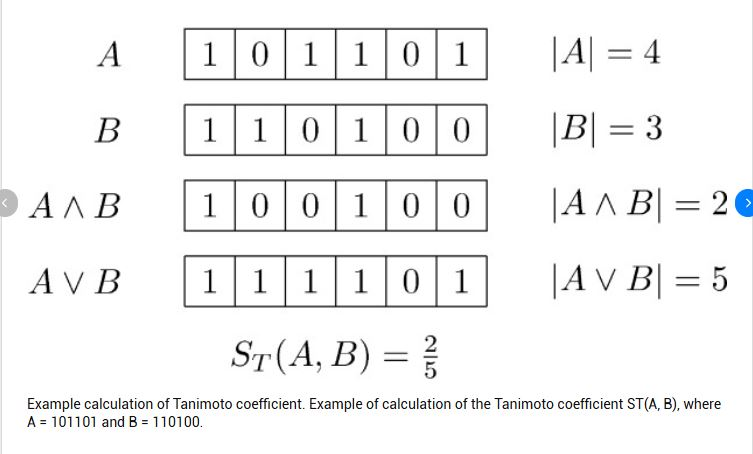

<a href="https://www.researchgate.net/figure/Example-calculation-of-Tanimoto-coefficient-Example-of-calculation-of-the-Tanimoto_fig6_40846565"><img src="https://www.researchgate.net/publication/40846565/figure/fig6/AS:282026340044802@1444251727106/Example-calculation-of-Tanimoto-coefficient-Example-of-calculation-of-the-Tanimoto.png" alt="Example calculation of Tanimoto coefficient. Example of calculation of the Tanimoto coefficient ST(A, B), where A = 101101 and B = 110100."/></a>

Com isso, continuarei com o desenvolvimento do projeto seguindo o artigo, considerando apenas a similaridade entre valores iguais a 1.

In [11]:
## Definição da função com índice de Tanimoto
# Utilizando bitarray a forma da função teve que ser alterada (anteriormente utilizava listas).
# Essa abordagem elimina a comparação elemento a elemento de uma lista, reduzindo o custo computacional.

def tanimoto_bits(a, b):
    inter = (a & b).count()
    union = (a | b).count()
    return inter / union if union > 0 else 0.0

## 4. Paralelização com MapPartitions

In [12]:
## Definição do nível de similaridade desejado
similaridade = 0.5

In [13]:
## Criação do RDD particionado
# Transforma os dados (indivíduos) em um RDD, distribuído em 200 partições.
# Cada partição é processada de forma independente e paralela pelos executores.

rdd = sc.parallelize(individuos, numSlices=200)

In [14]:
## Função para calcular os vizinhos
# Compara os indivíduos da partição com todos os armazenados em broadcast.

def calcular_vizinhos(partition):
    data = broadcast_individuos.value
    for id_a, feat_a in partition:
        vizinhos = []
        for id_b, feat_b in data:
            if id_a < id_b:
                calculo_similaridade = tanimoto_bits(feat_a, feat_b)
                if calculo_similaridade >= similaridade:
                    vizinhos.append(id_b)
        yield (id_a, vizinhos)

In [15]:
## Aplicação de mapPartitions
# Chama a função uma vez por partição, ao invés de chamar por elemento

vizinhos_rdd = rdd.mapPartitions(calcular_vizinhos)

In [16]:
## Coleta controlada dos vizinhos
# Traz os dados distribuídos nos executores Spark novamente para o driver.
# É controlada pois os dados já foram processados e reduzidos, com uma lista de vizinhos por indivíduo.

vizinhos = dict(vizinhos_rdd.collect())

In [17]:
## Ordena os indivíduos com mais vizinhos
# Cada indivíduo é representado por (id, lista_vizinhos).
# No sorted, len(x[1]) é o número de vizinhos de cada indivíduo.
# O reverse é necessário pois sorted organiza por ordem crescente e necessito de ordem decrescente.

ordenado = sorted(
    vizinhos.items(),
    key=lambda x: len(x[1]),
    reverse=True
)

## 5. Montar os Clusters

In [18]:
## Montagem das esferas de exclusão do Butina, ou os Clusters.
# Cada iteração seleciona um centróide e forma a esfera de exclusão, contendo os vizinhos de acordo com o nível de similaridade.
# O flagged marca individuos que já foram utilizados em um cluster, garantindo que não sejam centróides nem estejam em outros clusters.

clusters_finais = []
flagged = set()
singletons = set()

for centro, vizinhos in ordenado:
    if centro in flagged:
        continue

    cluster = {centro}
    for v in vizinhos:
        if v not in flagged:
            cluster.add(v)

    if len(cluster) == 1:
        singletons.add(centro)
    else:
        clusters_finais.append((centro, cluster))

    flagged.update(cluster)


In [19]:
print("Clusters encontrados:")
for i, (centroide, elementos) in enumerate(clusters_finais, start=1):
    print(f"Cluster {i} (centróide = {centroide}): tamanho = {len(elementos)}")



Clusters encontrados:
Cluster 1 (centróide = 20799): tamanho = 361
Cluster 2 (centróide = 1273): tamanho = 244
Cluster 3 (centróide = 17170): tamanho = 197
Cluster 4 (centróide = 14406): tamanho = 203
Cluster 5 (centróide = 1238): tamanho = 179
Cluster 6 (centróide = 18858): tamanho = 167
Cluster 7 (centróide = 4005): tamanho = 150
Cluster 8 (centróide = 19214): tamanho = 153
Cluster 9 (centróide = 4703): tamanho = 136
Cluster 10 (centróide = 12731): tamanho = 133
Cluster 11 (centróide = 1219): tamanho = 136
Cluster 12 (centróide = 11231): tamanho = 128
Cluster 13 (centróide = 18186): tamanho = 126
Cluster 14 (centróide = 917): tamanho = 118
Cluster 15 (centróide = 15277): tamanho = 107
Cluster 16 (centróide = 3346): tamanho = 106
Cluster 17 (centróide = 34207): tamanho = 99
Cluster 18 (centróide = 40039): tamanho = 106
Cluster 19 (centróide = 4325): tamanho = 104
Cluster 20 (centróide = 23293): tamanho = 91
Cluster 21 (centróide = 4745): tamanho = 98
Cluster 22 (centróide = 14904): ta

In [20]:
print("\nQuantidade de singletons:", len(singletons))


Quantidade de singletons: 42541
